<a href="https://colab.research.google.com/github/SharmilNK/XAI/blob/main/GlobalExplanations_SN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Global Explanations

### Sharmil N K

Use the classic UCI adult income dataset. This is a classification task to predict if people made over $50k in the 1990's.

Train an XGBoost classifier model with default parameters for explanatory purposes. Perform a 50-50 train/test split for optimization purposes.



Please use this to connect your GitHub repository to your Google Colab notebook.
Connects to any needed files from GitHub and Google Drive

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "XAI" # Change to your repo name
git_path = 'https://github.com/SharmilNK/XAI.git' #Change to your path
!git clone "{git_path}"

In [ ]:
!git config --global user.name "SharmilNK"
!git config --global user.email "sharmilsomaiah@gmail.com"

In [ ]:
#Make sure Jupyter kernel is using the same Python where your packages are installed.

#Switch to Kernel Python3.11.9 and run
!C:\Users\USR\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip setuptools wheel

#1. Open a terminal/command prompt in environment and run:

python -m pip install ipykernel

(Replace python with the exact path if needed, e.g.
C:\Users\USR\AppData\Local\Programs\Python\Python311\python.exe -m pip install ipykernel)

Note: To find the path, in Python run:
import sys
print(sys.executable)

#2. Add this environment to Jupyter, run:

python -m ipykernel install --user --name custom-kernel-name --display-name "Python (custom-kernel-name)"

#This will create a new kernel option in Jupyter.

#3. Switch Kernel in Jupyter, Open collab notebook.
#Go to the top menu → Kernel → Change Kernel. Pick "Python (custom-kernel-name)" (or the name given by user).

To upgrade pip run : !C:\Users\USR\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip setuptools wheel

In [ ]:

!c:\Users\USR\AppData\Local\Programs\Python\Python310\python.exe -m pip install numpy==1.25.2 pandas==2.0.3 scikit-learn==1.2.2 shap==0.45.1 git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
!c:\Users\USR\AppData\Local\Programs\Python\Python310\python.exe -m pip install xgboost

In [ ]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
import xgboost as xgb
from sklearn.model_selection import train_test_split

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

import llvmlite
import numba

np.random.seed(1)

c:\Users\som\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load Data from shap library
X,y = shap.datasets.adult()
'''
X = features (Age, Education, Work Hours, etc.)
y = labels from the UCI Adult dataset : 0 = income ≤ $50k , 1 = income > $50k
model predicts for positive class i.e y=1, whether income exceeds $50k/yr based on census data.
'''
# Train XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = xgboost.XGBClassifier().fit(X_train, y_train)


[7 6 4 1 2 0 5 8 3]


***Partial Dependence Plots (PDP) 📈***

A Partial Dependence Plot (PDP or PD) shows the marginal effect one or two features have on the predicted outcome of a model.

How it Works:

Select feature of interest
For every instance in training dataset:
Keep all other features the same, create variants of the instance by replacing the feature’s value with values from a grid
Make predictions with the black box model for newly created instances
You now have a set of points for an instance with the feature value from the grid and the respective predictions
Average across all instances and plot
and we will build our own implementation in numpy.

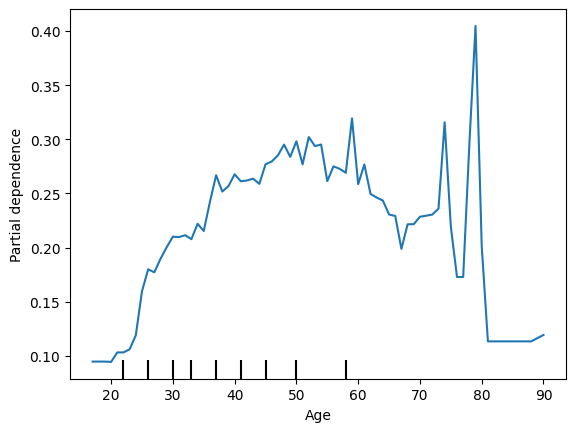

In [ ]:
# Use built-in library : scikit learn's Partial Dependence Display
# Choose the feature of interest
features = ["Age"]

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average') #kind='both'

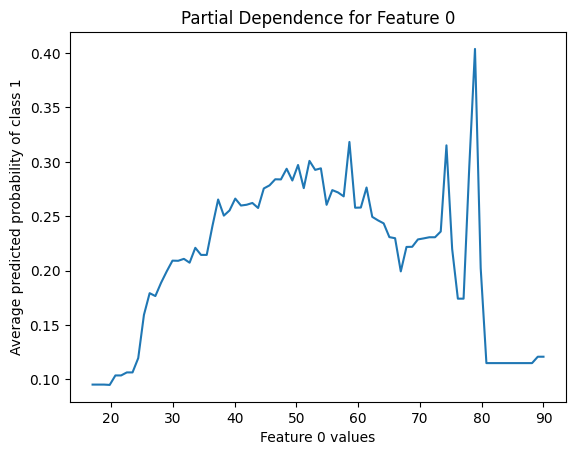

In [ ]:
# Build own grid of values and change the size of grid. (This is why we see slight variations between the PDP created with numpy versus the PartialDependenceDisplay from scikit learn.)
# Choose the feature for which you want to plot partial dependence
feature_index = 0  # For example, the first feature

# Create feature grid - here is where you can update the size of the grid by updating num
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=80)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Duplicate the dataset to modify feature values
X_modified = X.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for all instances
    X_modified.iloc[:, feature_index] = value

    # Predict using the modified dataset
    predictions = model.predict_proba(X_modified)[:, 1]

    # Calculate average prediction for the current feature value
    average_predictions[i] = np.mean(predictions)

# Plot the partial dependence for the chosen feature
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature {feature_index} values')
plt.ylabel('Average predicted probability of class 1')
plt.title(f'Partial Dependence for Feature {feature_index}')
plt.show()

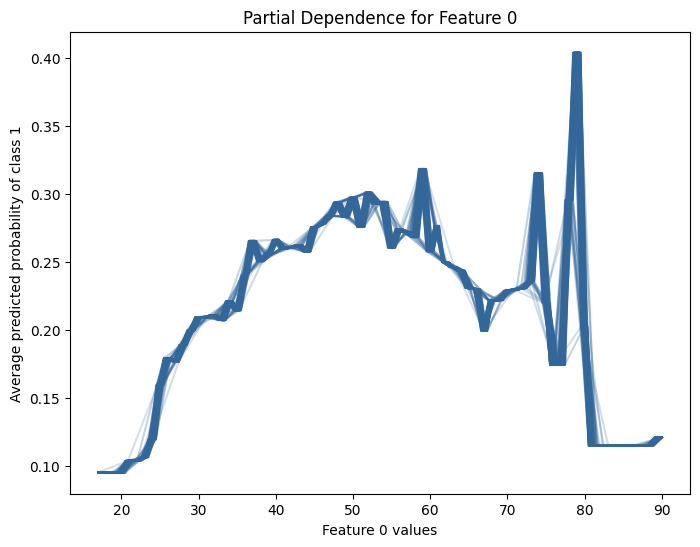

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

grid_length = np.linspace(20, 120, 40)
fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and axis for plotting

# Define a base color and alpha (transparency) values
base_color = (0.2, 0.4, 0.6)  # Blue-ish color
min_alpha = 0.2
max_alpha = 1.0

# Normalize grid_length values between 0 and 1
normalized_g = (grid_length - grid_length.min()) / (grid_length.max() - grid_length.min())

for i, g in enumerate(grid_length):
    # Create feature grid
    feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=int(g))
    # Initialize array to store average predictions
    average_predictions = np.zeros_like(feature_values)
    # Duplicate the dataset to modify feature values
    X_modified = X.copy()
    # Loop over feature values
    for j, value in enumerate(feature_values):
        # Set the chosen feature to the current value for all instances
        X_modified.iloc[:, feature_index] = value
        # Predict using the modified dataset
        predictions = model.predict_proba(X_modified)[:, 1]
        # Calculate average prediction for the current feature value
        average_predictions[j] = np.mean(predictions)
    # Calculate color based on normalized g
    alpha = min_alpha + (max_alpha - min_alpha) * normalized_g[i]
    color = to_rgba(base_color, alpha)
    # Plot the partial dependence for the chosen feature
    ax.plot(feature_values, average_predictions, color=color)

ax.set_xlabel(f'Feature {feature_index} values')
ax.set_ylabel('Average predicted probability of class 1')
ax.set_title(f'Partial Dependence for Feature {feature_index}')
plt.show()


# Interpretation:

X axis: Variants of the feature Age , when all other features are kept constant.

Y axis: Predicted probablity of income > $50k (while varying Age and all other features are kept constant.)

Interpretation:

The curve is not linear. In the initial years the curve rises steadily (probablity of earning an income of >$50k increases). After age =60 years, the curve declines.

Below 20years, we see a flat line which indicates that any variation in the feature variable has little effect on the prediction.

For lower age groups 20-25years the probablity of earning an income of >$50k is very low (<12%>). This is because of lower work experience.

For age group ~21 to 58 years the probablity goes on rising steadily as their experience grows.

From 58 years there is a decline,(close to retiring age) decreasing the probablity of earning an income of >$50k but at ~68 years there is a strong dip observed and the probablity touches ~20%.

From 60 years (retiring age) the probablity goes on decreasing and there is a strong dip at 65 years.

At around 75–80 years, there are strong fluctuations with sharp spikes and sharp dips. This seems seems irrelevant based on intuition. These could be instability from very few samples at extreme ages.

Post 80years, we see a flat line which indicates that any variation in the feature variable has little effect on the prediction.



***ALE Plots 📉***

Accumulated Local Effects (ALE) Plots

How to create an ALE plot:

Bin the Feature: Divide the feature of interest into several intervals (bins). These bins help in managing the data and computing local effects within smaller, more manageable segments.
Compute Local Effects: For each bin, calculate the local effect of the feature on the prediction. This involves: Calculating the change in prediction when moving from the lower to the upper edge of the bin Averaging this change over all instances that fall into that bin
Accumulate Effects: Starting from the first bin, accumulate the local effects across all bins. Sum up the average effects sequentially to show how the feature influences the prediction as its value changes
Centering: To make the plot more interpretable, center the accumulated effects around zero. Subtract the mean of the accumulated effects, which forces the interpretation to focus on deviations from the average prediction
There are a few python implementations of ALE plots, here we show the ALEPython implementation.

The implementation is more complex and less intuitive than PDPs, with many hyperparameters, including:

bins - This parameter defines the number of bins to divide the range of the specified feature into. A larger number of bins can provide more granularity in the ALE plot but might also increase computation time.
monte_carlo - This parameter is a boolean flag indicating whether to use Monte Carlo sampling to estimate the ALE. Monte Carlo sampling can be beneficial when the number of samples in the dataset is large, as it reduces computational burden.
monte_carlo_rep - This parameter specifies the number of Monte Carlo replicates to use for estimating the ALE. More replicates can lead to a more accurate estimation but may also increase computation time.
monte_carlo_ratio - This parameter determines the proportion of the dataset to use for Monte Carlo sampling. It's a value between 0 and 1, where 1 means using the entire dataset. Using a smaller ratio can speed up computation but may introduce some sampling error.

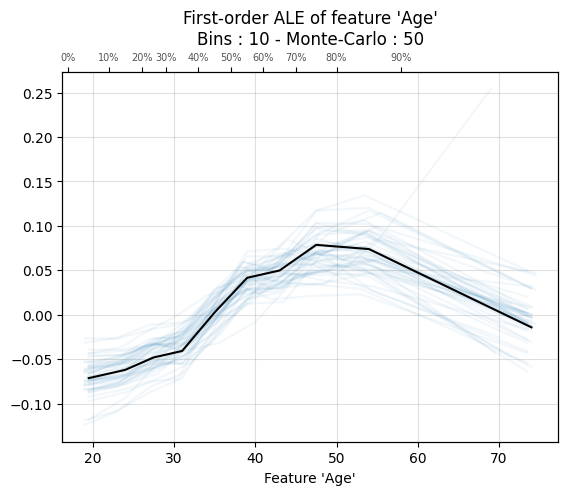

<Axes: title={'center': "First-order ALE of feature 'Age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'Age'">

In [ ]:
# Use default parameters for 1D Main Effect ALE Plot
ale_plot(model, X_train, 'Age', monte_carlo=True)

# Interpretation:

X axis: Variants of the feature Age , when all other features are kept constant.

Y axis: ALE value (centered effect of predicted probablity of income > $50k)

Interpretation:

Until ~35 years, ALE < 0. This means that there is a lower probability of earning an income >$50k.

From ~35–50 years, the ALE value rises above 0. This indicates a higher probability of earning an income >$50k.

After ~55–75 years, the ALE vaule starts declining. This indicates that the probability of earning an income >$50k decreases.


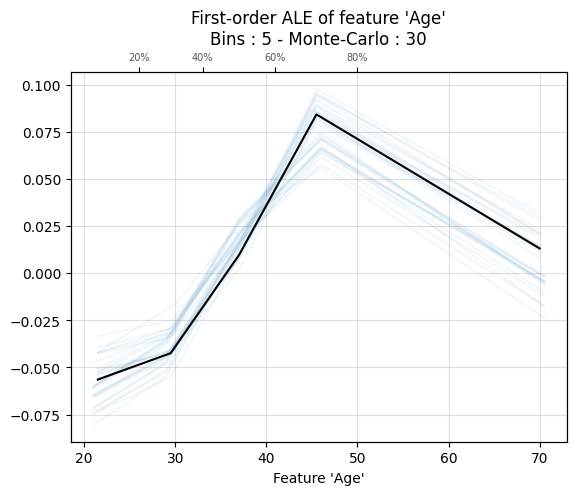

<Axes: title={'center': "First-order ALE of feature 'Age'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'Age'">

In [ ]:
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "Age",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

# Interpretation:

X axis: Variants of the feature Age , when all other features are kept constant.

Y axis: ALE value (centered effect of predicted probablity of income > $50k)

Interpretation:

This plot is consistant with the first ALE plot. Since it uses fewer bins, it’s smoother but less detailed.

Until ~35 years, ALE < 0. This means that there is a lower probability of earning an income >$50k.

From ~35–45 years, the ALE value rises above 0. This indicates a higher probability of earning an income >$50k.

After ~45 years, the ALE vaule starts declining. This indicates that the probability of earning an income >$50k decreases.

***How to Interpret - 2D Second-Order ALE Plot***
Both axes represent the values of the two features being analyzed.
Each axis corresponds to one of the features.
The plot displays a surface where the height represents the average effect on predictions. Higher points indicate regions where the model tends to make higher predictions, and vice versa.
Patterns in the surface reveal how the joint behavior of the two features affects the model's predictions. Peaks or valleys suggest regions where the joint effect is particularly strong.
The direction of the slope indicates whether increasing one feature while holding the other constant tends to increase or decrease predictions. Steeper slopes represent larger effects, while flatter regions indicate smaller effects.

In [ ]:
''' The two features used are - Age, Workclass. ALE plots (alepython) only accept numeric featues for 2D plots. Since Workclass is categorical,
need a library that supports categorical features in ALE plots, like PyALE instead of alepython.'''

!C:\Users\USR\AppData\Local\Programs\Python\Python311\python.exe -m pip install PyALE
from PyALE import ale

The system cannot find the path specified.


Workclass,0,2,4,6,8
Age,,,,,
17.0,-0.009558,0.000870,-0.010632,0.059442,0.125420
22.0,-0.009558,0.000870,-0.010632,0.059442,0.125420
26.0,0.018155,-0.001003,-0.010297,0.044028,0.118481
30.0,0.005004,-0.004278,-0.005126,0.053199,0.093169
33.0,-0.003967,-0.003249,0.003595,0.031748,-0.010851
37.0,-0.110703,0.023679,0.013349,-0.063122,-0.105720
41.0,-0.010682,0.008406,0.005545,-0.043356,-0.044576
45.0,0.045803,0.036066,-0.030668,-0.043533,-0.076804
50.0,0.012265,-0.007572,0.014988,-0.030266,-0.056915


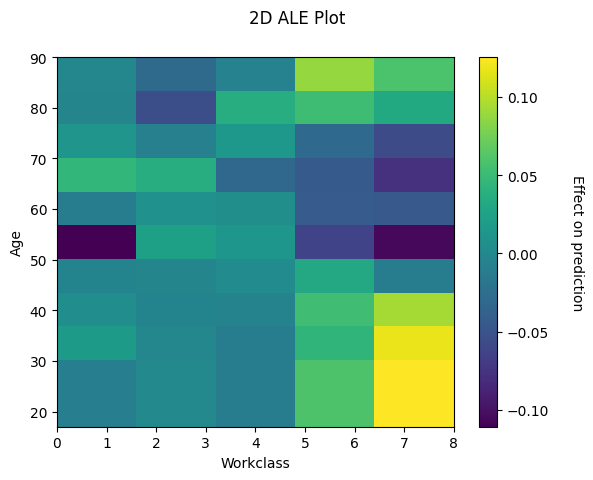

In [ ]:
# 2D Second-Order ALE Plot
#ale_plot(model, X_train, X_train.columns[:2], bins=10)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X['Workclass_enc'] = le.fit_transform(X['Workclass'])

ale(
    X=X.drop(columns=['Workclass_enc']),
    model=model,
    feature=['Age','Workclass'],
    grid_size=10
)

# Interpretation:

X-axis: Age

Y-axis: Workclass (job type categories encoded numerically 0-8) i.e.

0 = Federal-gov     
1 = Local-gov       
2 = Never-worked        
3 = Private     
4 = Self-emp-inc        
5 = Self-emp-not-inc        
6 = State-gov       
7 = Without-pay     
8 = Unknown     

Color scale: ALE effect on prediction of earning >$50k:

    Yellow (~ +0.10): Strong positive effect (higher chance of earning income >$50k).

    Blue/Purple (~ –0.10): Strong negative effect (lower chance of earning income >$50k).

    Green/Teal (~0.0): Neutral effect

Interpretation:

For ages between 20–50 years, maximum the income differences is found based on the workclass.

    Private (≈4): This workclass shows a moderate positive effect as middle-aged workers in private sector are more likely to cross $50k.

    Self-emp-inc (≈5): This workclass shows a strong positive effect as business owners tend to earn more in their 30s–40s.

    Self-emp-not-inc (≈6): This workclass shows weaker effect than corporate, but is still sometimes positive for ages between 30–40 years.

    Government jobs (≈1,2,7): This workclass is generally neutral to slightly positive.

    Without-pay (≈8) & Never-worked (≈3) workclasses sho a strong negative effect.

    Unknown(≈0): Inconsistent, is often neutral or slightly negative.

For ages 60-80 years, being older(closer to retirement) reduces the earnings probablity irrespective of the workclass.

    Across all workclasses, effect trends negative or near zero.

    Even high-earning groups (Private, Self-emp-inc) flatten out or drop back down.


Strong negative signals: The workclasses- Without-pay, Never-worked have almost no chance of earning an income of >$50k, regardless of age.

Strong positive signals: The workclasses- Private & Self-emp-inc around ages 30–50years have a higher chance of earning an income of >$50k.

Neutral: The workclasses- Federal gov, Local gov, State gov show moderate earning incomes

**Comparing PDP and ALE plots :**

**PDP** curves show multiple variations (sharp rises and falls, or too flat). This is because they average over impossible combinations of features (e.g., 18-year-olds with PhDs).

PDP: Y-axis shows predicted probability directly (e.g., probability of income >50k).


**ALE** curves look smoother and more realistic, because they only use regions where specific data exists.

ALE: Y-axis shows the change relative to average prediction.

  
Example,

For Age:

**PDP** might show a continuous rise with age, suggesting that as one grows older they have a higher probablity of a higher income.

**ALE** breaks it down to show:

For ages <20 years, the AL value is strongly negative indicating low income.

For 30–50 years, ALE = strongly positive since it is a persons peak earning years.

Over 60yearsthe ALE value starts declining(retirement)

That “rise then fall” pattern is more realistic — and only ALE captures it.


Example, For correlated features

Age and Education are correlated in the Adult dataset.

PDP for Age might suggest that older ages = higher income, but that’s partly because older people also have more work experience and education.

ALE for Age will separate those effects and show the true local influence of age itself.





***Permutation Feature Importance***
The importance of a feature can be measured by calculating how much model’s prediction error increases after permuting the feature.

If shuffling a feature’s values increases the model error, the feature is important
If the model error doesn’t change after shuffling a feature’s values, a feature is considered unimportant
First introduced for random forests Paper, 2001. Updated to be model agnostic - renamed “model reliance” Paper, 2018.

Process for Model Agnostic measure:
Input: Trained model 𝑓^, feature matrix 𝑋, target vector 𝑦, error measure 𝐿(𝑦,𝑓^).
Estimate the original model error 𝑒𝑜𝑟𝑖𝑔=𝐿(𝑦,𝑓^(𝑋)) (e.g. mean squared error)
For each feature 𝑗∈{1,...,𝑝}:
Generate feature matrix 𝑋𝑝𝑒𝑟𝑚 by permuting feature j in the data X. This breaks the association between feature j and true outcome y
Estimate error 𝑒𝑝𝑒𝑟𝑚=𝐿(𝑌,𝑓^(𝑋𝑝𝑒𝑟𝑚)) based on the predictions of the permuted data.
Calculate permutation feature importance as quotient 𝐹𝐼𝑗=𝑒𝑝𝑒𝑟𝑚/𝑒𝑜𝑟𝑖𝑔 or difference 𝐹𝐼𝑗=𝑒𝑝𝑒𝑟𝑚 - 𝑒𝑜𝑟𝑖𝑔
Sort features by descending FI
Implementation in Python Here we will demonstrate the implementation in the scikit-learn library.[Documentation Here]

The scikit-learn implementation of the permutation_importance function calculates the feature importance of estimators for a given dataset. The n_repeats parameter sets the number of times a feature is randomly shuffled and returns a sample of feature importances.

n_repeats - number of times to permute a feature

In [ ]:
# Compute permutation importances
perm_imp = permutation_importance(model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [ ]:
# Print the mean and standard deviation of permutation importances for each feature

for i in perm_imp.importances_mean.argsort()[::-1]:
    if perm_imp.importances_mean[i] - 2 * perm_imp.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
              f"{perm_imp.importances_mean[i]:.3f}"
              f" +/- {perm_imp.importances_std[i]:.3f}")

Capital Gain0.050 +/- 0.001
Relationship0.036 +/- 0.002
Education-Num0.031 +/- 0.002
Occupation0.018 +/- 0.002
Age     0.018 +/- 0.002
Capital Loss0.012 +/- 0.001
Hours per week0.009 +/- 0.001
Marital Status0.007 +/- 0.001
Workclass0.005 +/- 0.001


# Interpretation:

The mean indicats the average drop in model performance (accuracy, F1, etc.) when that feature is shuffled.

The std dev indicates how stable that importance is across multiple shuffles. Here the std deviations for all featurs are tiny (≤0.002) i.e. the model’s reliance on each feature is very stable, there is no big randomness.

1. Capital Gain (0.050 ± 0.001)

The mean indicates that it is a strong feature and shuffling it would reduce the model's performance by a lot. The std deviation is low which indicates that it's importance is consistance across multiple shuffles i.e. it is very stable.

This could be because, high capital gains are strongly tied to high income (>$50k).


2. Relationship (0.036 ± 0.002)

It is the second most important feature based on the mean. The std deviation indicates slightly higher variability.

Relationship status is a big income signal.


3. Education-Num (0.031 ± 0.002)

This is an importnt feature too, logically formal years of education has a strong positive effect on income.


4. Occupation & Age (0.018 ± 0.002 each) & Capital Loss (0.012 ± 0.001)

These featurs are moderately important. Occupatin, age, losses (in tax/investments) are moderate indicators of a higher income bracket.


5. Hours per week (0.009 ± 0.001) & Marital Status (0.007 ± 0.001)

These features have a lower mean indicating low importance. The hours worked or martial status doesn’t separate between income holders of >$50k or <$50k


6. Workclass (0.005 ± 0.001)

This is the weakest feature. The job sector (private, gov, self-emp) adds very little once occupation, education, and capital gains are known.




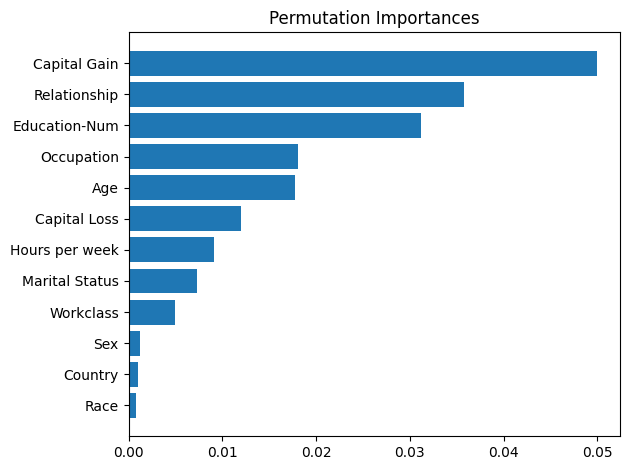

In [ ]:
# Plot Permutation Feature Importances as a bar chart

sorted_idx = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], perm_imp.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

# Permutation Feature Importances with bar graph:

Top drivers: Capital Gain, Relationship, Education.

Moderate: Occupation, Age, Capital Loss

Weak: Workclass, Marital Status, Hours per week.

Almost no importance: Sex, Country, Race

The model isn’t heavily driven by demographic bias (at least in PFI terms).


The model is learning mostly from financial & human-capital features (Capital Gain, Education, Occupation). Demographic features (Sex, Race, Country) contribute to almost nothing.
Maritial status is surprisingly strong, which might hide social/economic bias (e.g., “Husband” associated with primary earners in 1990s data).

C:\Users\som\AppData\Local\Temp\ipykernel_5836\2492236719.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(perm_imp.importances[sorted_idx].T,


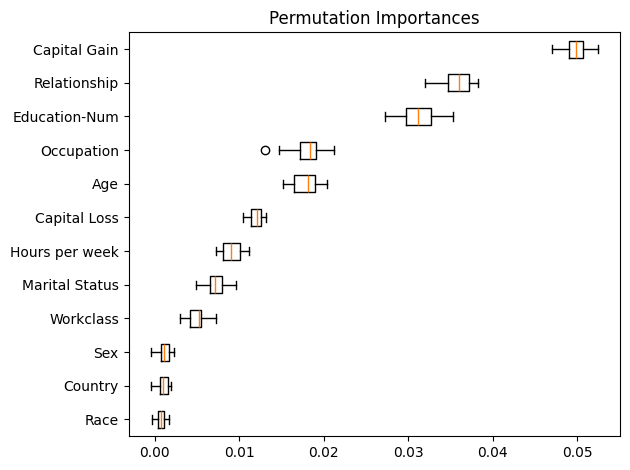

In [ ]:
# Plot Permutation Feature Importances as a box plot

fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

# Permutation Feature Importances with boxplots:

Box (center line + quartiles): Distribution of importance values across multiple random shuffles.

Whiskers: Range of variation.

Dots (outliers): Occasional extreme values.

1. Capital Gain (~0.05) is the most important feature with very little variability, showing that the model consistently relies on it.

2. Relationship (~0.036) is a strong feature with some variability across shuffles but remains one of the top predictors.

3. Education-Num (~0.031) is also a strong and reliable predictor, though its importance varies slightly across runs.

4. Occupation (~0.018) has a moderate impact with some variability, making it useful but less dominant. The outlier indicates that in one particular shuffle, the model’s performance dropped much less (or more) than usual.

5. Age (~0.018) contributes moderately, with importance that can shift relative to Occupation.

6. Capital Loss (~0.012) provides a small but stable contribution that is consistent across shuffles.

7. Hours per week (~0.009) adds a weak but steady signal to the model’s predictions.

8. Marital Status (~0.007) offers a minor but consistent effect, reinforcing some predictive value.

9. Workclass (~0.005) is a weak and somewhat unstable feature that the model does not rely on heavily.

10. Sex (<0.005) has almost no impact, indicating that the model does not use it in predictions.

11. Country (<0.005) is effectively ignored by the model, showing negligible importance.

12. Race (<0.005) contributes nothing meaningful, which is good from a fairness perspective since it avoids demographic bias.

The boxplots confirm stability i.e. the model is consistently using the same top features.

**Correlation between features**

                     Age  Education-Num  Capital Gain  Capital Loss  \
Age             1.000000       0.036527      0.077674      0.057775   
Education-Num   0.036527       1.000000      0.122630      0.079923   
Capital Gain    0.077674       0.122630      1.000000     -0.031615   
Capital Loss    0.057775       0.079923     -0.031615      1.000000   
Hours per week  0.068756       0.148123      0.078409      0.054256   

                Hours per week  
Age                   0.068756  
Education-Num         0.148123  
Capital Gain          0.078409  
Capital Loss          0.054256  
Hours per week        1.000000  


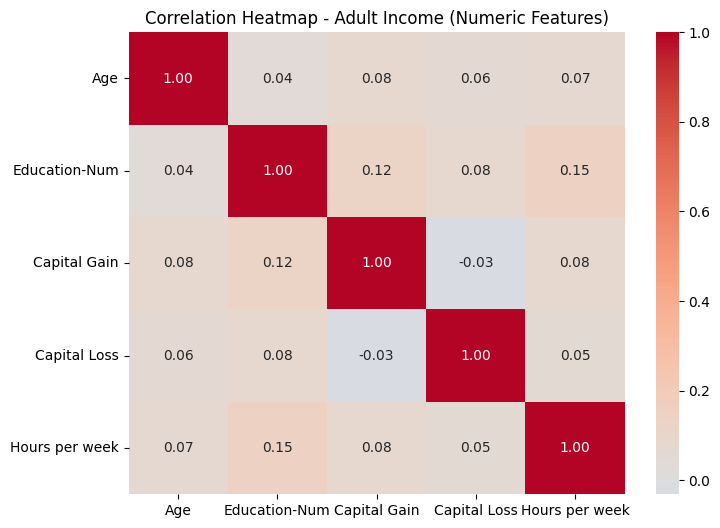

In [3]:
# Select only numeric columns
numeric_cols = ['Age','Education-Num','Capital Gain','Capital Loss','Hours per week']
X_numeric = X[numeric_cols]

# Compute correlation matrix
corr = X_numeric.corr()

# Print correlation values
print(corr)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap - Adult Income (Numeric Features)")
plt.show()

Age has a weak correlations with other features (0.04–0.08).

The years of education has the highest correlation with Hours per week (0.15) and Capital Gain (0.12). Altough the correlation is still weak it suggests that a person with higher education will clock in more work hours and have a higher investment activity.

Capital Gain vs Capital Loss (-0.03) has a negative correlation

None of the numeric features are strongly correlated (>0.5).

This means numeric collinearity isn’t a big issue in this model.



*Citation: All interpretaions were not generated using AI. AI was used only as a referrence to understand how to read the plots.*

In [ ]:
from google.colab import userdata
userdata.get('secretName')